In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.spatial.distance import cdist
from scipy.stats import zscore
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering

In [2]:
df=pd.read_csv('final.csv')

In [3]:
# Current date for recency and tenure calculation
current_date = datetime(2024, 12, 31)



In [4]:
df.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,ProductName,Category,Price,CustomerName,Region,SignupDate,TotalValue,tnMonth,tWeek,tYear,VariantID
0,T00001,C0199,P067,2024-08-25,1,comfortliving bluetooth speaker,Electronics,300.68,Andrea Jenkins,Europe,2022-12-03,300.68,8,6,2024,1
1,T00166,C0127,P067,2024-04-25,1,comfortliving bluetooth speaker,Electronics,300.68,Kathryn Stevens,Europe,2024-04-04,300.68,4,3,2024,1
2,T00363,C0070,P067,2024-03-21,3,comfortliving bluetooth speaker,Electronics,300.68,Timothy Perez,Europe,2022-03-15,902.04,3,3,2024,1
3,T00442,C0188,P067,2024-12-26,1,comfortliving bluetooth speaker,Electronics,300.68,Anna Ball,South America,2022-05-17,300.68,12,3,2024,1
4,T00490,C0195,P067,2024-11-24,3,comfortliving bluetooth speaker,Electronics,300.68,Jeremy Mclaughlin,South America,2024-09-17,902.04,11,6,2024,1


In [5]:
df.shape

(799, 16)

In [6]:
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])
df['SignupDate'] = pd.to_datetime(df['SignupDate'])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 799 entries, 0 to 798
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   TransactionID    799 non-null    object        
 1   CustomerID       799 non-null    object        
 2   ProductID        799 non-null    object        
 3   TransactionDate  799 non-null    datetime64[ns]
 4   Quantity         799 non-null    int64         
 5   ProductName      799 non-null    object        
 6   Category         799 non-null    object        
 7   Price            799 non-null    float64       
 8   CustomerName     799 non-null    object        
 9   Region           799 non-null    object        
 10  SignupDate       799 non-null    datetime64[ns]
 11  TotalValue       799 non-null    float64       
 12  tnMonth          799 non-null    int64         
 13  tWeek            799 non-null    int64         
 14  tYear            799 non-null    int64    

In [8]:
df# Aggregate customer-level features
customer_features = df.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'TransactionID': 'count',
    'ProductID': pd.Series.nunique,
    'TransactionDate': lambda x: (current_date - x.max()).days,
    'SignupDate': lambda x: (current_date - x.min()).days
}).reset_index()

In [9]:
customer_features.columns = [
    'CustomerID', 'TotalSpend', 'TransactionCount', 'ProductDiversity', 'Recency', 'Tenure'
]


In [10]:
# Exclude non-numeric columns before computing correlation
correlation_matrix = customer_features.select_dtypes(include=['number']).corr()
print(correlation_matrix)


                  TotalSpend  TransactionCount  ProductDiversity   Recency  \
TotalSpend          1.000000          0.840855          0.822482 -0.190062   
TransactionCount    0.840855          1.000000          0.988009 -0.239110   
ProductDiversity    0.822482          0.988009          1.000000 -0.238271   
Recency            -0.190062         -0.239110         -0.238271  1.000000   
Tenure              0.375169          0.446434          0.438894  0.177814   

                    Tenure  
TotalSpend        0.375169  
TransactionCount  0.446434  
ProductDiversity  0.438894  
Recency           0.177814  
Tenure            1.000000  


In [11]:
# Remove highly correlated features
customer_features_cleaned = customer_features.drop(columns=['TransactionCount'])

In [12]:
# Apply log transformation to skewed features (e.g., 'TotalSpend')
customer_features_cleaned['TotalSpend'] = np.log1p(customer_features_cleaned['TotalSpend'])


In [13]:
customer_features_cleaned

,CustomerID,TotalSpend,ProductDiversity,Recency,Tenure
0,C0001,8.118362,5,59,905
1,C0002,7.530341,4,28,1052
2,C0003,7.864812,3,129,299
3,C0004,8.585950,8,8,814
4,C0005,7.618369,3,57,869
...,...,...,...,...,...
178,C0196,8.513964,3,16,938
179,C0197,7.565094,3,4,651
180,C0198,6.838223,2,88,1038
181,C0199,7.590994,4,66,759


In [14]:
# Select features for clustering
features = customer_features_cleaned[['TotalSpend', 'ProductDiversity', 'Recency', 'Tenure']]


In [15]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [16]:
# Calculate Z-scores for each feature
z_scores = np.abs(zscore(scaled_features))

In [17]:
z_scores

array([[4.40096212e-01, 3.34940828e-01, 1.58382275e-01, 1.08024761e+00],
       [2.40114851e-01, 1.15751610e-01, 6.68315673e-01, 1.55417394e+00],
       [1.46794451e-01, 5.66444047e-01, 9.93080236e-01, 8.73489514e-01],
       [9.80992591e-01, 1.68701814e+00, 9.97304962e-01, 7.86864639e-01],
       [1.38285284e-01, 5.66444047e-01, 1.91281204e-01, 9.64184014e-01],
       [7.07609638e-01, 1.15751610e-01, 2.69303801e-01, 6.80050195e-01],
       [1.36442171e-01, 5.66444047e-01, 9.76630772e-01, 1.15117536e+00],
       [7.19595036e-01, 2.58840302e+00, 8.98608176e-01, 6.99394127e-01],
       [1.08540507e+00, 5.66444047e-01, 1.87056478e-01, 2.09347853e-01],
       [3.33934628e-01, 1.15751610e-01, 3.88674778e-01, 5.70857400e-01],
       [5.62795252e-01, 3.34940828e-01, 1.04665336e+00, 5.80529365e-01],
       [3.50742632e-01, 5.66444047e-01, 1.03020389e+00, 1.36675978e+00],
       [5.24363112e-01, 1.15751610e-01, 1.74831740e-01, 1.10884069e+00],
       [7.90136075e-01, 1.01713648e+00, 5.32495232e

In [18]:
threshold = 3  # Outliers beyond this threshold will be removed
outliers = (z_scores > threshold).all(axis=1)

# Remove outliers
customer_features_cleaned_no_outliers = customer_features_cleaned[~outliers]
scaled_features_cleaned = scaled_features[~outliers]

In [19]:
customer_features_cleaned_no_outliers

,CustomerID,TotalSpend,ProductDiversity,Recency,Tenure
0,C0001,8.118362,5,59,905
1,C0002,7.530341,4,28,1052
2,C0003,7.864812,3,129,299
3,C0004,8.585950,8,8,814
4,C0005,7.618369,3,57,869
...,...,...,...,...,...
178,C0196,8.513964,3,16,938
179,C0197,7.565094,3,4,651
180,C0198,6.838223,2,88,1038
181,C0199,7.590994,4,66,759


In [20]:
# Dimensionality Reduction using PCA
pca = PCA(n_components=2)
data_pca = pca.fit_transform(scaled_features_cleaned)
print(f"Explained Variance Ratio: {pca.explained_variance_ratio_.sum():.4f}")

Explained Variance Ratio: 0.8189


In [21]:
def kmeans_custom_distance(data, n_clusters, metric):
    # Compute pairwise distances
    distance_matrix = cdist(data, data, metric=metric)

    # Apply KMeans with KMeans++ initialization
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
    cluster_labels = kmeans.fit_predict(data)

    # Evaluation
    silhouette = silhouette_score(distance_matrix, cluster_labels, metric="precomputed")
    db_index = davies_bouldin_score(data, cluster_labels)
    print(f"KMeans ({metric}) - Clusters: {n_clusters}, Silhouette: {silhouette:.4f}, DB Index: {db_index:.4f}")
    return cluster_labels

# Test KMeans with different distance metrics
for i in range(2,11):
  n=i
  for metric in ["euclidean", "cosine"]:
    kmeans_labels=kmeans_custom_distance(data_pca, n_clusters=n, metric=metric)


KMeans (euclidean) - Clusters: 2, Silhouette: 0.3771, DB Index: 1.0280
KMeans (cosine) - Clusters: 2, Silhouette: 0.6073, DB Index: 1.0280
KMeans (euclidean) - Clusters: 3, Silhouette: 0.4147, DB Index: 0.8515
KMeans (cosine) - Clusters: 3, Silhouette: 0.6309, DB Index: 0.8515
KMeans (euclidean) - Clusters: 4, Silhouette: 0.3638, DB Index: 0.8230
KMeans (cosine) - Clusters: 4, Silhouette: 0.5239, DB Index: 0.8230
KMeans (euclidean) - Clusters: 5, Silhouette: 0.3868, DB Index: 0.7897
KMeans (cosine) - Clusters: 5, Silhouette: 0.2209, DB Index: 0.7897
KMeans (euclidean) - Clusters: 6, Silhouette: 0.3713, DB Index: 0.8391
KMeans (cosine) - Clusters: 6, Silhouette: 0.0875, DB Index: 0.8391
KMeans (euclidean) - Clusters: 7, Silhouette: 0.4092, DB Index: 0.7798
KMeans (cosine) - Clusters: 7, Silhouette: 0.2780, DB Index: 0.7798
KMeans (euclidean) - Clusters: 8, Silhouette: 0.4224, DB Index: 0.7268
KMeans (cosine) - Clusters: 8, Silhouette: 0.1878, DB Index: 0.7268
KMeans (euclidean) - Cluste

In [22]:
kmeans_labels = kmeans_custom_distance(data_pca, n_clusters=8, metric='euclidean')

KMeans (euclidean) - Clusters: 8, Silhouette: 0.4224, DB Index: 0.7268


In [23]:
# Apply DBSCAN
dbscan = DBSCAN(eps=1.6, min_samples=10,metric='euclidean')
dbscan_labels = dbscan.fit_predict(data_pca)

In [24]:
# Apply Gaussian Mixture Model (GMM)
gmm = GaussianMixture(n_components=4, random_state=42)
gmm_labels = gmm.fit_predict(data_pca)

In [25]:
agglomerative = AgglomerativeClustering(n_clusters=4)
agglomerative_labels = agglomerative.fit_predict(scaled_features_cleaned)

Agglomerative Clustering is a distance-based clustering algorithm, and it typically works directly on the features themselves rather than the reduced dimensions from PCA

In [26]:
def evaluate_clustering(data, labels, model_name):
    if len(set(labels)) > 1:  # Avoid silhouette score errors when only one cluster is found
        silhouette = silhouette_score(data, labels)
        db_index = davies_bouldin_score(data, labels)
    else:
        silhouette = -1
        db_index = -1

    print(f"{model_name} - Silhouette Score: {silhouette:.4f}, DB Index: {db_index:.4f}")

# Evaluate models
evaluate_clustering(data_pca, dbscan_labels, "DBSCAN")
evaluate_clustering(data_pca, gmm_labels, "GMM")
evaluate_clustering(data_pca, agglomerative_labels, "Agglomerative Clustering")

DBSCAN - Silhouette Score: 0.4985, DB Index: 0.5352
GMM - Silhouette Score: 0.3719, DB Index: 0.7885
Agglomerative Clustering - Silhouette Score: 0.3064, DB Index: 0.8792


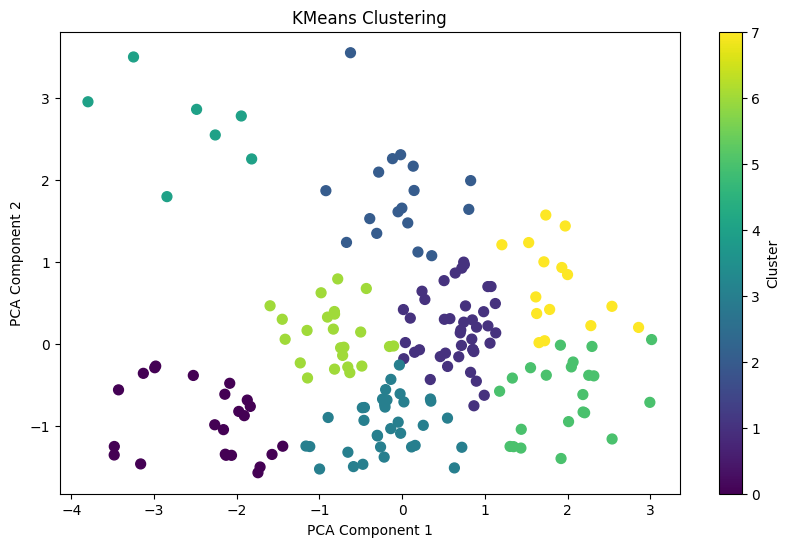

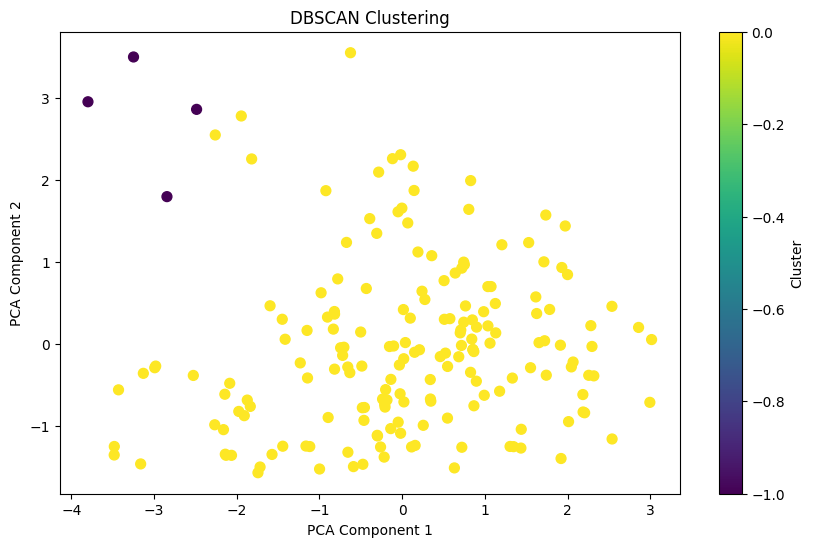

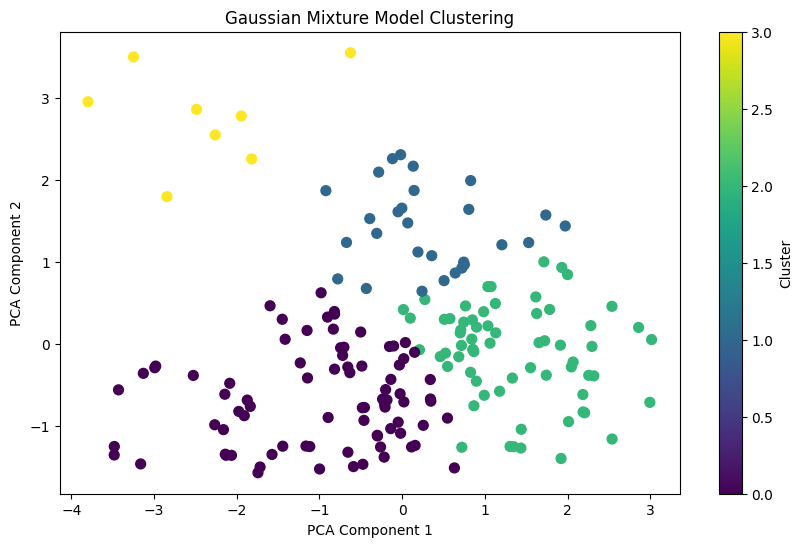

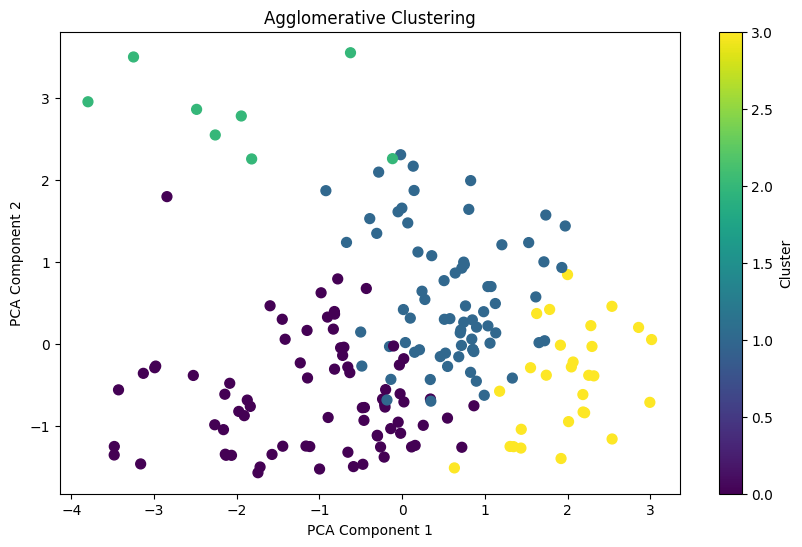

In [27]:
# Visualize KMeans clusters
plt.figure(figsize=(10, 6))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=kmeans_labels, cmap='viridis', s=50)  # Using KMeans labels
plt.title('KMeans Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

# Visualize DBSCAN clusters
plt.figure(figsize=(10, 6))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=dbscan_labels, cmap='viridis', s=50)  # Using DBSCAN labels
plt.title('DBSCAN Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

# Visualize GMM clusters
plt.figure(figsize=(10, 6))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=gmm_labels, cmap='viridis', s=50)  # Using GMM labels
plt.title('Gaussian Mixture Model Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

# Visualize Agglomerative Clustering results
plt.figure(figsize=(10, 6))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=agglomerative_labels, cmap='viridis', s=50)  # Using Agglomerative labels
plt.title('Agglomerative Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()


In [28]:
import numpy as np
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.spatial.distance import cdist

# Calculate cluster sizes for KMeans
unique_labels_kmeans, counts_kmeans = np.unique(kmeans_labels, return_counts=True)
print(f"KMeans Clusters Sizes:")
for label, count in zip(unique_labels_kmeans, counts_kmeans):
    print(f"Cluster {label}: {count} points")

# Silhouette Score and Davies-Bouldin Index
silhouette_kmeans = silhouette_score(data_pca, kmeans_labels)
db_index_kmeans = davies_bouldin_score(data_pca, kmeans_labels)

print(f"KMeans (Silhouette Score): {silhouette_kmeans:.4f}")
print(f"KMeans (Davies-Bouldin Index): {db_index_kmeans:.4f}")


KMeans Clusters Sizes:
Cluster 0: 23 points
Cluster 1: 42 points
Cluster 2: 17 points
Cluster 3: 34 points
Cluster 4: 7 points
Cluster 5: 22 points
Cluster 6: 23 points
Cluster 7: 15 points
KMeans (Silhouette Score): 0.4224
KMeans (Davies-Bouldin Index): 0.7268


In [29]:
# Calculate cluster sizes for Agglomerative Clustering
unique_labels_agg, counts_agg = np.unique(agglomerative_labels, return_counts=True)
print(f"Agglomerative Clustering Sizes:")
for label, count in zip(unique_labels_agg, counts_agg):
    print(f"Cluster {label}: {count} points")

# Silhouette Score and Davies-Bouldin Index
silhouette_agg = silhouette_score(data_pca, agglomerative_labels)
db_index_agg = davies_bouldin_score(data_pca, agglomerative_labels)

print(f"Agglomerative Clustering (Silhouette Score): {silhouette_agg:.4f}")
print(f"Agglomerative Clustering (Davies-Bouldin Index): {db_index_agg:.4f}")



Agglomerative Clustering Sizes:
Cluster 0: 76 points
Cluster 1: 71 points
Cluster 2: 8 points
Cluster 3: 28 points
Agglomerative Clustering (Silhouette Score): 0.3064
Agglomerative Clustering (Davies-Bouldin Index): 0.8792


In [30]:
# Calculate cluster sizes for GMM
unique_labels_gmm, counts_gmm = np.unique(gmm_labels, return_counts=True)
print(f"GMM Clusters Sizes:")
for label, count in zip(unique_labels_gmm, counts_gmm):
    print(f"Cluster {label}: {count} points")

# Silhouette Score and Davies-Bouldin Index
silhouette_gmm = silhouette_score(data_pca, gmm_labels)
db_index_gmm = davies_bouldin_score(data_pca, gmm_labels)

print(f"GMM (Silhouette Score): {silhouette_gmm:.4f}")
print(f"GMM (Davies-Bouldin Index): {db_index_gmm:.4f}")


GMM Clusters Sizes:
Cluster 0: 81 points
Cluster 1: 28 points
Cluster 2: 66 points
Cluster 3: 8 points
GMM (Silhouette Score): 0.3719
GMM (Davies-Bouldin Index): 0.7885


In [31]:
# Compute unique cluster labels and their counts for DBSCAN
unique_labels_dbscan, counts_dbscan = np.unique(dbscan_labels, return_counts=True)
print(f"DBSCAN Clusters Sizes:")
for label, count in zip(unique_labels_dbscan, counts_dbscan):
    print(f"Cluster {label}: {count} points")

# Compute Silhouette Score and Davies-Bouldin Index for DBSCAN
silhouette_dbscan = silhouette_score(data_pca, dbscan_labels)
db_index_dbscan = davies_bouldin_score(data_pca, dbscan_labels)

print(f"DBSCAN (Silhouette Score): {silhouette_dbscan:.4f}")
print(f"DBSCAN (Davies-Bouldin Index): {db_index_dbscan:.4f}")


DBSCAN Clusters Sizes:
Cluster -1: 4 points
Cluster 0: 179 points
DBSCAN (Silhouette Score): 0.4985
DBSCAN (Davies-Bouldin Index): 0.5352
